# Laser Scanning Confocal Microscopy
Esta es la técnica usada para obtener las imágenes. Se puede ver un video muy lindo del funcionamiento en la página de Wikipedia [Confocal microscopy](https://en.wikipedia.org/wiki/Confocal_microscopy). También ayuda a enternder cómo se hace el slicing en $z$ el ver en el diagrama de rayos cómo los de otros planos focales son bloqueados by the pin hole:
![Z slicing in confocal microscopy](confocal_microscopy_z_slicing.png)

# Imports

In [61]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Opening Images Imports
import czifile
from pathlib import Path
from lxml import etree

# Visualizing Images Imports
import napari
from napari.utils import nbscreenshot

# Filtering Images Imports
from scipy.ndimage import gaussian_filter
from skimage import morphology
from skimage import img_as_float
from skimage.morphology import reconstruction
from skimage.restoration import rolling_ball
from skimage.morphology import disk, white_tophat
from skimage import exposure
from skimage import filters
from pyclesperanto_prototype import imshow

from stardist.models import StarDist2D


# Opening the Image
## Loading the CZI object
Las imágenes vienen in a proprietary format called CZI, que pertenece a la empresa que hace el microscopio (Zeiss). Para trabajar con estos archivos, hay una biblioteca específica llamada `czifile`. Los metadatos asociados se encuentran en formato XML en el CZI. Para parsearlo uso `lxml`, la biblioteca más completa para trabajar con XML. En particular, brinda soporte para trabajar con XPath, un lenguaje para realizar consultas a archivos XML (it's a query language for navigatin XML documents).

Napari uses Qt for Graphical User Interface (GUI) so we must first create the Qt application before we can get started with `napari`.

In [2]:
%gui qt

In [3]:
# Instantiate a Path object
czi_file_path = Path(r"./ESTA - Sph1 Z Stack - CTRL SOX2.czi")

# Read the image and get the CziFile object
with czifile.CziFile(czi_file_path) as czi:
    img = czi.asarray()  # Store image data in 'img' variable
    czi_object = czi  # Store the CziFile object

    # Extract a string containing the XML metadata
    metadata_xml_str = czi.metadata()
    # If you want the metadata as a dictionary instead of XML, you can use
    # metadata_dict = czi.metadata(raw=False)
    
    metadata_tree = etree.fromstring(metadata_xml_str.encode('utf-8'))

    # Save the metadata to an XML file
    with open('metadata.xml', 'wb') as f:
        f.write(etree.tostring(metadata_tree, pretty_print=True))


In [4]:
# We can see that the array has 8 dimensions
img.shape

(1, 1, 3, 1, 9, 2292, 2292, 1)

In [5]:
# We can get the shape from the array or from the czi object
czi_shapeinfo = czi.shape
czi_shapeinfo

(1, 1, 3, 1, 9, 2292, 2292, 1)

To know what is what, we look at the `axes` string attribute, and interpret it according to the Information CZI Dimension Characters:
```python
- '0': 'Sample',  # e.g. RGBA
- 'X': 'Width',
- 'Y': 'Height',
- 'C': 'Channel',
- 'Z': 'Slice',  # depth
- 'T': 'Time',
- 'R': 'Rotation',
- 'S': 'Scene',  # contiguous regions of interest in a mosaic image
- 'I': 'Illumination',  # direction
- 'B': 'Block',  # acquisition
- 'M': 'Mosaic',  # index of tile for compositing a scene
- 'H': 'Phase',  # e.g. Airy detector fibers
- 'V': 'View',  # e.g. for SPIM
```

In [6]:
# axes will give a string describing them
czi_dimstring = czi.axes
czi_dimstring

'BVCTZYX0'

So, according to this, `img` is an array of:
- B = 1, so one block
- V = 1, so one view
- C = 3, so three channels (which makes sense, they are the optic channel, the one indicating the nuclei and the SOX2 channel)
- T = 1, so a single time frame (i.e. no $t$ component)
- Z = 9, so 9 $z$ slices
- Y = 2292, so we have that many pixels in the $y$ direction (height)
- X = 2292, idem (note that we have a square image)
- '0' = 1, indicating that we have a single sample

## Dealing with the XML Metadata
Primero intenté navegar el XML de manera simple con `pandas`, pero no anduvo, así que tuve que parsear a mano con `lxml`.

In [7]:
# We define functions for parsing
def list_children(node):
    """
    List direct children of an XML node.
    """
    return [child.tag for child in node]

def get_node(path, root_node):
    """
    Retrieve a specific node by path.
    """
    elements = root_node.xpath(path)
    if elements:
        return elements[0]
    else:
        raise ValueError(f"No node found for path: {path}")

def view_content(path, root_node):
    """
    Display the content of a specific node.
    """
    node = get_node(path, root_node)
    return etree.tostring(node, pretty_print=True).decode()

def view_shallow_content(path, root_node):
    """
    Display the immediate children of a specific node without nested elements.
    """
    node = get_node(path, root_node)
    result = f"<{node.tag}>\n"
    for child in node:
        result += f"  <{child.tag}>\n"
    result += f"</{node.tag}>"
    return result

def view_tags(path, root_node):
    """
    Display the tags of the immediate children of a specific node.
    """
    node = get_node(path, root_node)
    result = [child.tag for child in node]
    return result

def get_attributes(path, root_node):
    """
    Get the attributes of a specific node.
    """
    node = get_node(path, root_node)
    return node.attrib


In [8]:
# Load the XML
root = etree.parse('metadata.xml').getroot()

In [9]:
# Example Usage:
# List children of root
print(list_children(root))

['Metadata']


In [10]:
# We view the content of 'Metadata'
print(view_content('//Metadata',root_node=root))

<Metadata>
    <Version>1.0</Version>
    <Information>
      <User>
        <DisplayName>zeiss</DisplayName>
      </User>
      <Document>
        <Name>20230804 03 CTRL SOX2</Name>
        <Description/>
        <Comment/>
        <UserName>zeiss</UserName>
        <CreationDate>2023-08-04T10:34:08</CreationDate>
        <SubType>Image</SubType>
        <Rating>0</Rating>
        <Title>20230804 03 CTRL SOX2</Title>
      </Document>
      <Image>
        <OriginalScanData>true</OriginalScanData>
        <PixelType>Gray16</PixelType>
        <ComponentBitCount>16</ComponentBitCount>
        <SizeX>2292</SizeX>
        <SizeY>2292</SizeY>
        <SizeZ>9</SizeZ>
        <SizeC>3</SizeC>
        <MicroscopeRef Id="Microscope:0"/>
        <ObjectiveSettings>
          <ObjectiveRef Id="Objective:0"/>
          <Medium>Air</Medium>
          <RefractiveIndex>1</RefractiveIndex>
        </ObjectiveSettings>
        <Dimensions>
          <Channels>
            <Channel Id="3757360746127

In [11]:
# The previous was a lot, so let's see only first tags without attributes
print(view_tags('//Metadata', root_node=root))

['Version', 'Information', 'DisplaySetting', 'Scaling', 'Layers', 'Appliances', 'CustomAttributes', 'Experiment']


In [12]:
# We can now filter more easily, e.g., 'Metadata/Scaling' (which is specially interesting for us)
print(view_content('//Metadata/Scaling',root_node=root))

<Scaling>
      <Items>
        <Distance Id="X">
          <Value>1.2364633517553391e-007</Value>
        </Distance>
        <Distance Id="Y">
          <Value>1.2364633517553394e-007</Value>
        </Distance>
        <Distance Id="Z">
          <Value>1.9999999999999999e-006</Value>
        </Distance>
      </Items>
    </Scaling>
    



In [13]:
# Bigger nodes might still be to big to handle
print(view_content('//Information',root_node=root))


<Information>
      <User>
        <DisplayName>zeiss</DisplayName>
      </User>
      <Document>
        <Name>20230804 03 CTRL SOX2</Name>
        <Description/>
        <Comment/>
        <UserName>zeiss</UserName>
        <CreationDate>2023-08-04T10:34:08</CreationDate>
        <SubType>Image</SubType>
        <Rating>0</Rating>
        <Title>20230804 03 CTRL SOX2</Title>
      </Document>
      <Image>
        <OriginalScanData>true</OriginalScanData>
        <PixelType>Gray16</PixelType>
        <ComponentBitCount>16</ComponentBitCount>
        <SizeX>2292</SizeX>
        <SizeY>2292</SizeY>
        <SizeZ>9</SizeZ>
        <SizeC>3</SizeC>
        <MicroscopeRef Id="Microscope:0"/>
        <ObjectiveSettings>
          <ObjectiveRef Id="Objective:0"/>
          <Medium>Air</Medium>
          <RefractiveIndex>1</RefractiveIndex>
        </ObjectiveSettings>
        <Dimensions>
          <Channels>
            <Channel Id="3757360746127373822523333674793198833180" Name="Ch2-T1"

In [14]:
# So we repeat the process
print(view_tags('//Information', root_node=root))

['User', 'Document', 'Image', 'Instrument', 'Application']


Let us use these functions to extract something interesting. For instance, the scaling information

In [15]:
# We get the tags
print(view_tags('//Scaling/Items/Distance[1]', root_node=root))

['Value']


In [16]:
# We get the attributes
print(get_attributes('//Scaling/Items/Distance[1]', root_node=root))

{'Id': 'X'}


In [17]:
# The Value Tag in Distance Tag number 1 doesn't have any more tags
print(view_tags('//Scaling/Items/Distance[1]/Value[1]', root_node=root))

[]


In [18]:
# It doesn't have any attributes either
print(get_attributes('//Scaling/Items/Distance[1]/Value[1]', root_node=root))

{}


In [19]:
# However, the Value Tag has content: the X distance value
print(view_content('//Scaling/Items/Distance[1]/Value[1]', root_node=root))

<Value>1.2364633517553391e-007</Value>
        



# Visualizing the Image
In order to be abel to visualize interactively (while doing the procesing in the notebook with python), I'll use `napari`.

We know we have a 4D image. One trick to get rid of the unecessary extra dimentions is the [np.squeeze](https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html) function.

In [20]:
image_squeezed = np.squeeze(img)
image_squeezed.shape

(3, 9, 2292, 2292)

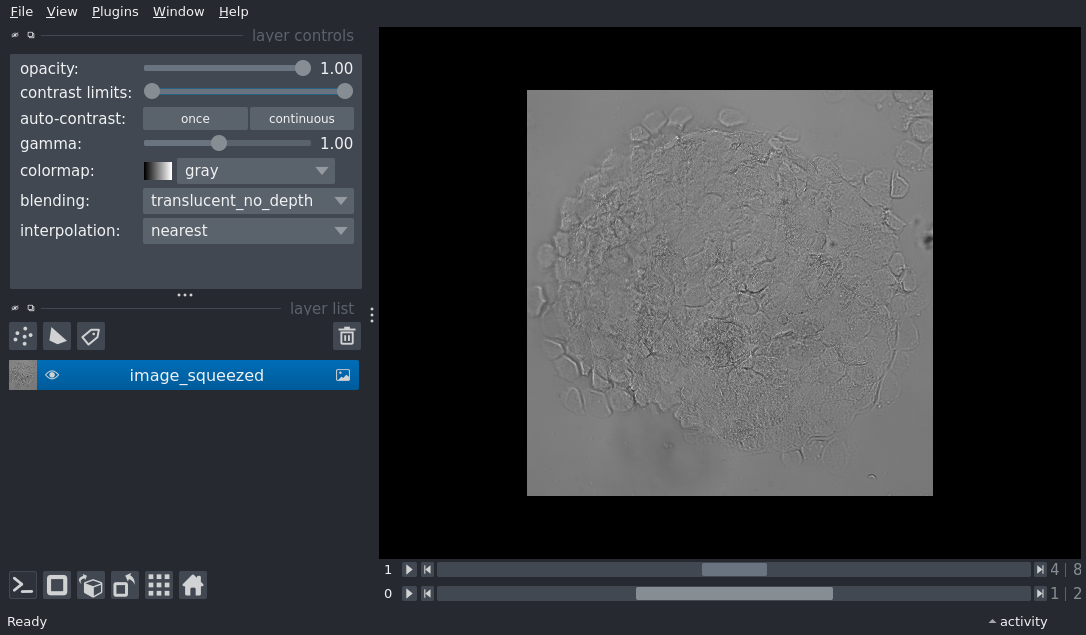

In [21]:
viewer = napari.Viewer()
viewer.add_image(image_squeezed)
nbscreenshot(viewer)

In [72]:
# Let's separate the channels:
# The first channel is the corresponding to stemness
stemness_channel = image_squeezed[0, :, :, :]
# Channel 2 is the optic one
optic_channel = image_squeezed[1, :, :, :]
# Channel 3 contains the nuclei
nuclei_channel = image_squeezed[2, :, :, :]

In [23]:
viewer = napari.Viewer()
viewer.add_image(nuclei_channel)

<Image layer 'nuclei_channel' at 0x7fc2081bbd00>

In [24]:
print(viewer.layers)

[<Image layer 'nuclei_channel' at 0x7fc2081bbd00>]


In [25]:
print('image_squeezed layer')
print('--------------------')
print('Colormap: ', viewer.layers['nuclei_channel'].colormap)
print('Contrast limits: ', viewer.layers['nuclei_channel'].contrast_limits)
print('Opacity: ', viewer.layers['nuclei_channel'].opacity)


image_squeezed layer
--------------------
Colormap:  colors=array([[0.        , 0.        , 0.        , 1.        ],
       [0.00392157, 0.00392157, 0.00392157, 1.        ],
       [0.00784314, 0.00784314, 0.00784314, 1.        ],
       ...,
       [0.99215686, 0.99215686, 0.99215686, 1.        ],
       [0.99607843, 0.99607843, 0.99607843, 1.        ],
       [1.        , 1.        , 1.        , 1.        ]], dtype=float32) name='gray' interpolation=<ColormapInterpolationMode.LINEAR: 'linear'> controls=array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
       0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.

In [26]:
# Now let's change some of them. Note that the viewer GUI will update in real time as you run this code in the notebook
viewer.layers['nuclei_channel'].colormap = 'blue'
viewer.layers['nuclei_channel'].contrast_limits = [0., 70000.]
viewer.layers['nuclei_channel'].opacity = 1.

# We can even rename the layer, but note that from now on you'll need to refer to if with its new name
# viewer.layers['nuclei_channel'].name = 'nuclei'

In [27]:
# We can do this directly like
# viewer.add_image(stemness_channel, contrast_limits=[0.07, 0.35], colormap='blue', blending='additive');
viewer.add_image(stemness_channel, colormap='red', blending='additive')

<Image layer 'stemness_channel' at 0x7fc1b6f3cf10>

In [28]:
print('Contrast limits: ', viewer.layers['stemness_channel'].contrast_limits)


Contrast limits:  [0.0, 65535.0]


In [29]:
viewer.add_image(optic_channel, colormap='gray', blending='additive')

<Image layer 'optic_channel' at 0x7fc23edcb550>

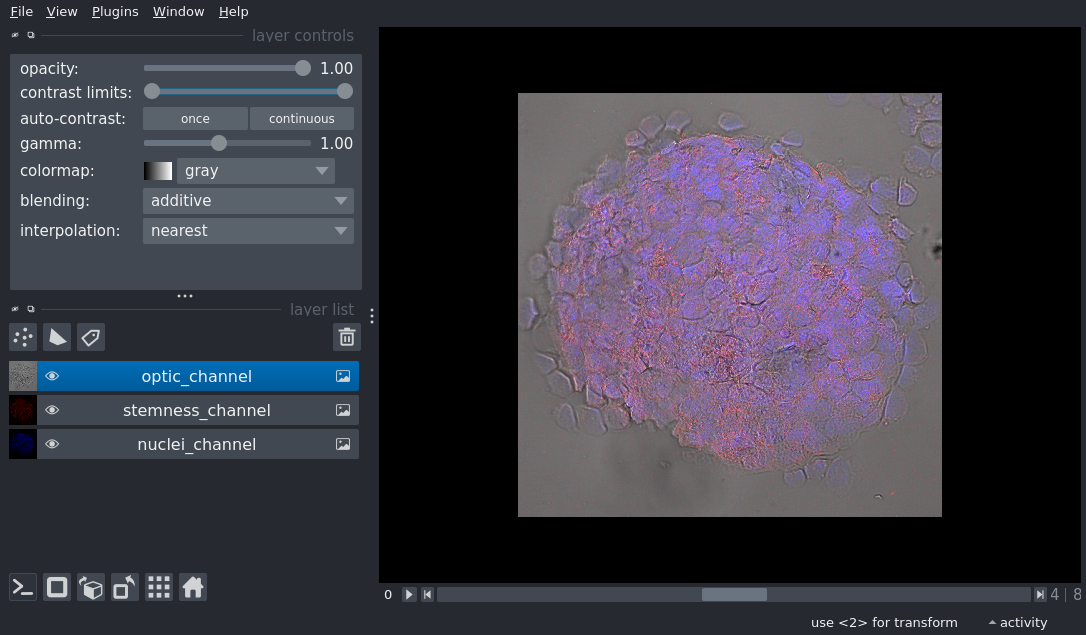

In [30]:
# We never close the napari window and can take a screenshot whenever we like
nbscreenshot(viewer)

In [31]:
# Note that changes made in the napari viewer have an impact here
print('Colormap: ', viewer.layers['optic_channel'].colormap)

# viewer.layers['optic_channel'].colormap = 'gray'


Colormap:  colors=array([[0.        , 0.        , 0.        , 1.        ],
       [0.00392157, 0.00392157, 0.00392157, 1.        ],
       [0.00784314, 0.00784314, 0.00784314, 1.        ],
       ...,
       [0.99215686, 0.99215686, 0.99215686, 1.        ],
       [0.99607843, 0.99607843, 0.99607843, 1.        ],
       [1.        , 1.        , 1.        , 1.        ]], dtype=float32) name='gray' interpolation=<ColormapInterpolationMode.LINEAR: 'linear'> controls=array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
       0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.152941

In [32]:
print('Contrast limits: ', viewer.layers['optic_channel'].contrast_limits)


Contrast limits:  [7170.0, 62543.0]


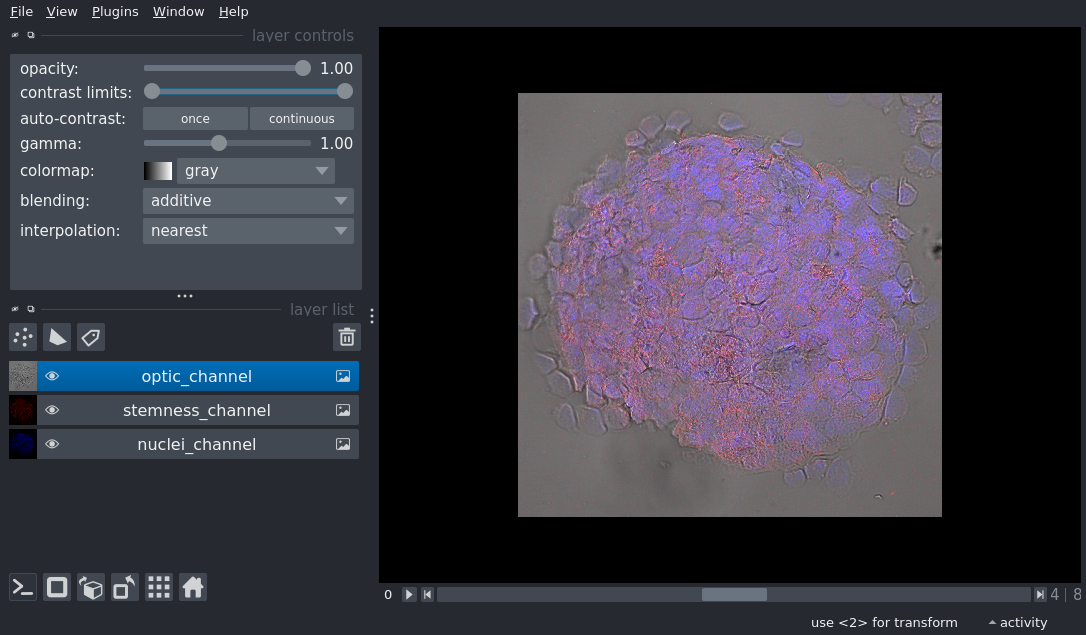

In [33]:
nbscreenshot(viewer)

Some comments about the viewer:
- In “File” there are options for saving a Screenshot to disc, both with and without the viewer
- The buttons on the bottom left corner are for:
    - Using an ipython command line (only when using napari as a stand alone application, not when you're using it from a notebook)
    - Showing/Hiding the bar that moves you through slices (when hiding, a 3D representation is attempted)
    - Rotate the order in which the axes are displaied (in this case is not that useful due to the small number of $z$ slices)
    - Transposing the image
    - Toggling grid mode (grid mode shows all the channels separately, organized in a grid)
 
Let's see an example of the 3D rendering

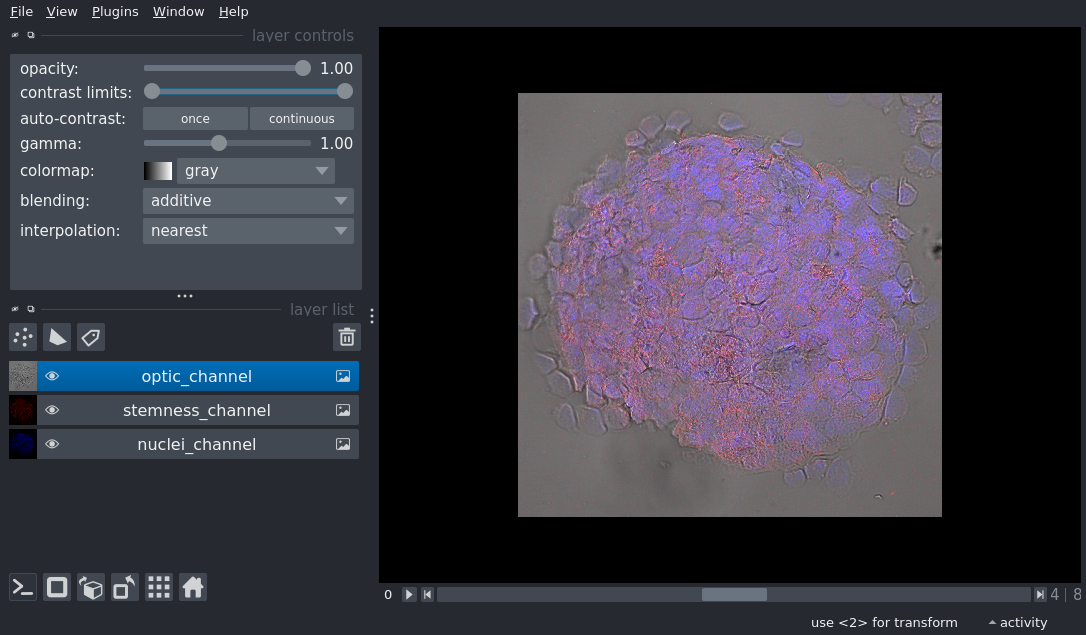

In [34]:
nbscreenshot(viewer)

Note: napari has some really powerful manual annotation tools, which I'm not interested in right now, but you can see a tutorial [here](https://github.com/sofroniewn/napari-training-course/blob/master/lessons/01_manual_annotation.ipynb) (with a video [here](https://www.youtube.com/watch?v=VgvDSq5aCDQ&t=1635s)).

Some important concepts are for instance the type of layers, cause it corresponds to the type of data:
- Image layer: the data corresponds to an array of pixels
- Shapes layer: the data contains vertices of any drew polygons; you can draw the polygons by indicating the vertices
- Labels layer: like a binary mask, but for many objects (so the values are integers, but not necessarily bools); you can paint with brushes on them
- Points layer: you can draw points (shperes) on them, mainly for anotation
- Surface layer: for meshes and vector fileds

You can also use `magicgui` to add key-bindings that execute some functions, and sliders for interactively modifying parameters.

## Accessing Individual Layers

In [35]:
# we can access the points as
viewer.layers['stemness_channel'].data

array([[[ 287, 1194, 2696, ..., 1122,  983,  744],
        [2354,  912, 1109, ...,  238, 1656, 2049],
        [ 125,  766,  895, ...,  275, 2724, 1743],
        ...,
        [ 414, 2057,  975, ..., 2404, 1087, 2974],
        [1129,  891,  467, ...,  641, 3074, 3031],
        [ 180, 1045,  292, ..., 1718, 1118, 2768]],

       [[ 551, 3659, 1363, ...,  990,  656, 2638],
        [3901,  648,  515, ...,  925,  297, 1853],
        [ 805,  316, 1853, ..., 2329, 1093, 1649],
        ...,
        [2185, 1018, 1112, ..., 1140, 1529,  847],
        [3570, 1000,  804, ..., 2324,  906, 1526],
        [1374,  337, 3118, ..., 1700,  278,  306]],

       [[1438,  121, 1112, ...,  395,  644, 1158],
        [ 343, 1535, 2104, ..., 1632, 1358, 2192],
        [ 327,  959, 1246, ..., 2345, 1699, 2419],
        ...,
        [ 140,  301, 1026, ..., 1340,  487,  339],
        [1694,  545,  547, ...,  297,  308, 1720],
        [ 303, 2536,  205, ...,  254, 1762, 2487]],

       ...,

       [[ 747, 1951,  43

In [36]:
# We can also query them by doing (this says that we have 9 slices -- z componenet)
len(viewer.layers['stemness_channel'].data)

9

In [37]:
# the number of y components can be accessed as with any array
len(viewer.layers['stemness_channel'].data[0])

2292

This is the way in which we can access, change, and reasign the values for the layers.

# Filtering the images
Napari is well integrated with scikit-image, so I'll that library for filtering. You can see an example usage [here](https://github.com/sofroniewn/napari-training-course/blob/master/lessons/02_interactive_analysis.ipynb).

My first-hand approach will be:
- a white top-hat morphology filter for the SOX2 layer
- gauusian/top-hat/thresholding and then stardist segmentation for the nuclei layer
- gaussian/closing and then watershed/cellpose cytoplasm segmentation for the optic layer

## SOX2 Layer

### Reconstruction
Let's first try using morphological reconstruction to create a background image, which we can subtract from the original image to isolate bright features (regional maxima). See the [Scikit-image example](https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_regional_maxima.html#sphx-glr-auto-examples-color-exposure-plot-regional-maxima-py).


In [38]:
stemness_array = np.copy(viewer.layers['stemness_channel'].data)

In [39]:
type(stemness_array)

numpy.ndarray

In [40]:
stemness_array.shape

(9, 2292, 2292)

In [42]:
# Convert to float
stemness_floats_array = img_as_float(stemness_array)

h = 0.5

seed = stemness_floats_array - h
mask = stemness_floats_array

dilated = reconstruction(seed, mask, method='dilation')
hdome = stemness_floats_array - dilated

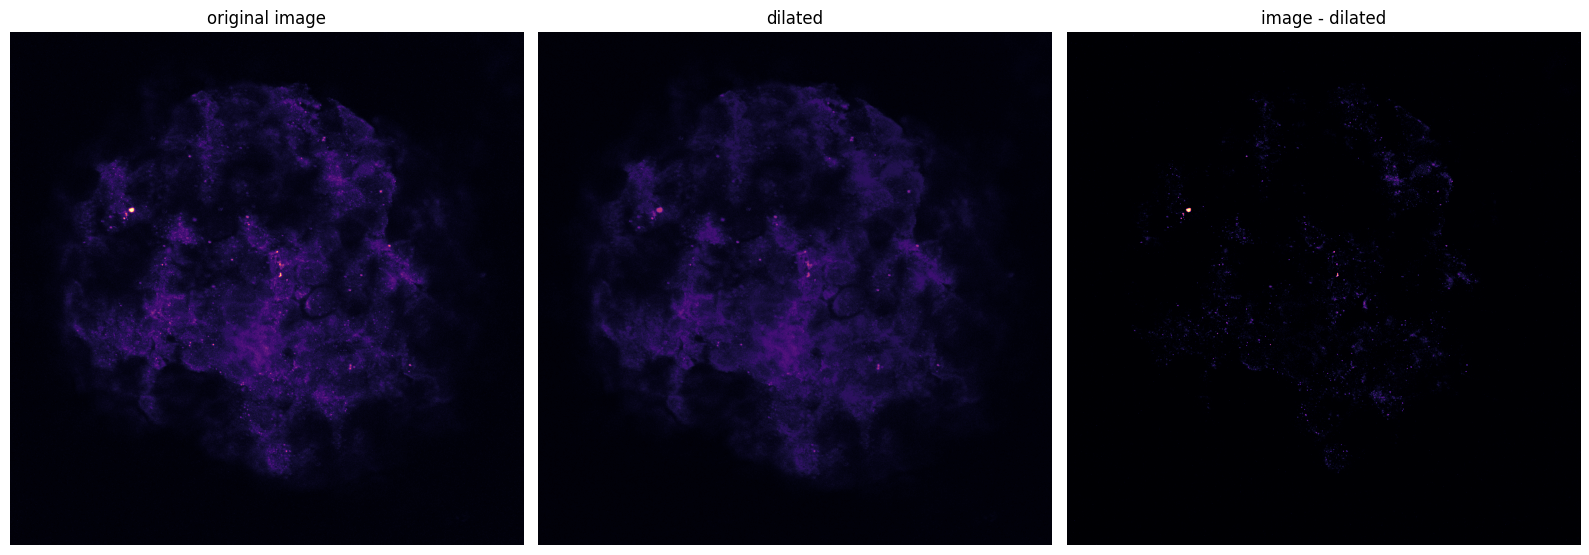

In [46]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(16, 8),
                                    sharex=True,
                                    sharey=True)

ax0.imshow(stemness_floats_array[3], cmap='magma')
ax0.set_title('original image')
ax0.axis('off')

ax1.imshow(dilated[3], vmin=stemness_floats_array[3].min(), vmax=stemness_floats_array[3].max(), cmap='magma')
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(hdome[3], cmap='magma')
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()

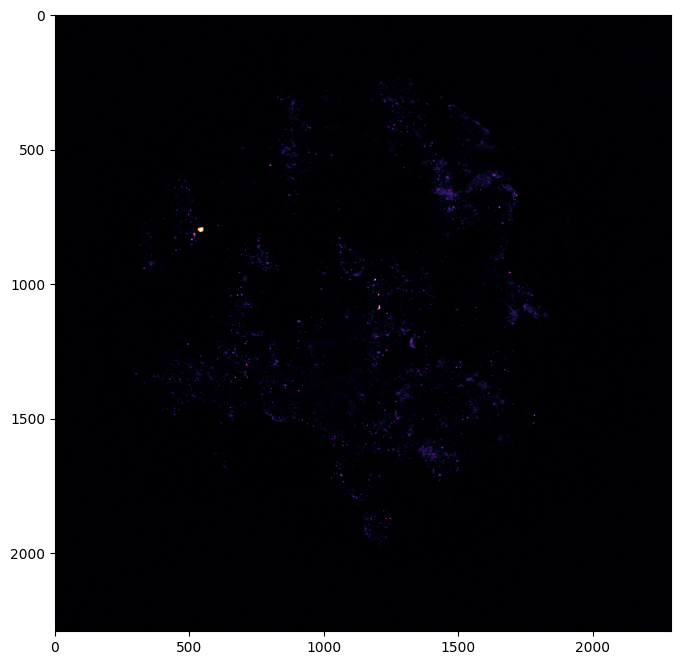

In [47]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(hdome[3], cmap='magma')
plt.show()

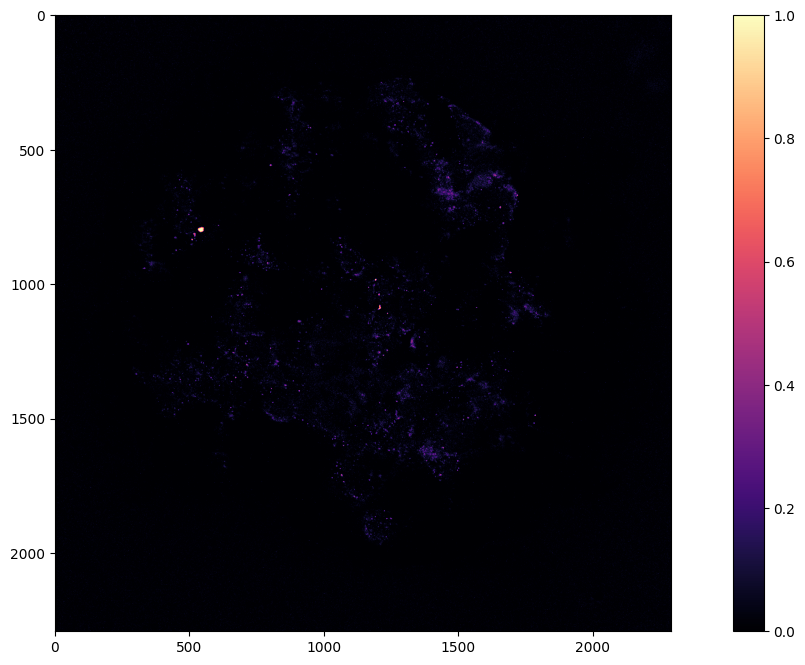

In [48]:
# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(hdome, clip_limit=0.03)

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(img_adapteq[3], cmap='magma')
fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap='magma'), ax=ax)
plt.show()

Mepa que lo mejorcito que puedo obtener es reconstrucción con h=0.5 y luego ecualización adaptativa.

In [49]:
viewer.add_image(img_adapteq, colormap='red');
print(viewer.layers)

[<Image layer 'nuclei_channel' at 0x7fc2081bbd00>, <Image layer 'stemness_channel' at 0x7fc1b6f3cf10>, <Image layer 'optic_channel' at 0x7fc23edcb550>, <Image layer 'img_adapteq' at 0x7fc1edfbd300>]


In [50]:
viewer.layers['img_adapteq'].name = 'SOX2-filtered'


Sigue teniendo bastante ruido, creo que voy a probar haciendo DoG (closing y top-hat no funcionaron).

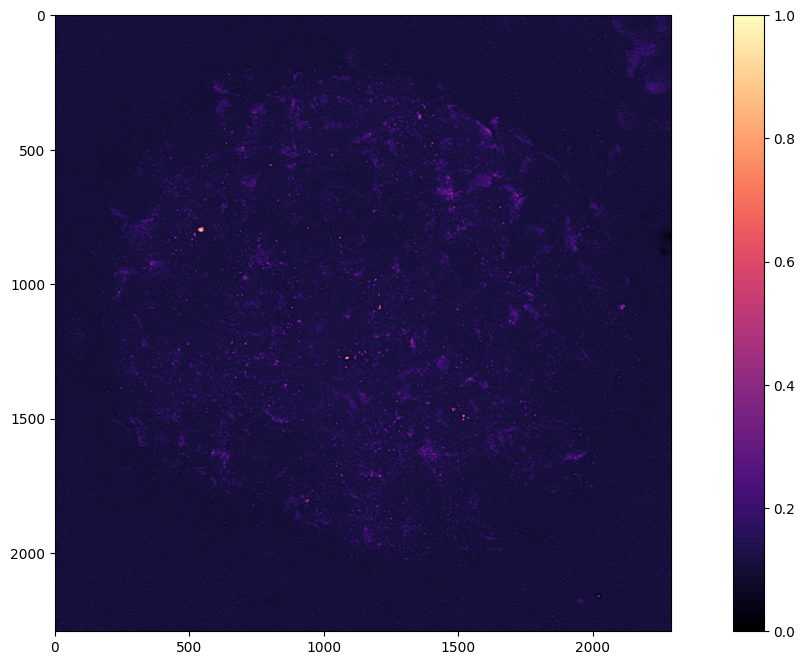

In [65]:
img_dog = filters.difference_of_gaussians(img_adapteq, low_sigma=2, high_sigma=None)
# img_tophat = white_tophat(img_adapteq) # , footprint=disk(50)

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(img_dog[3], cmap='magma')
fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap='magma'), ax=ax)
plt.show()

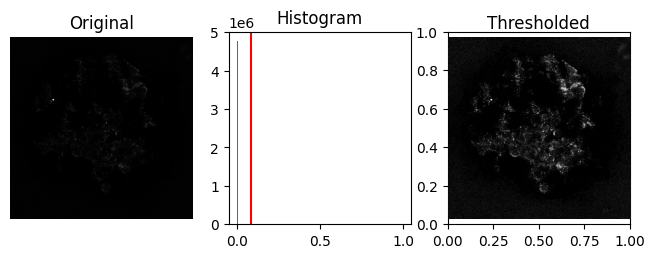

In [66]:
image = img_adapteq
thresh = filters.threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image[3], cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image[3].ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary[3], cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

In [64]:
viewer.layers['SOX2-filtered'].data = img_dog

## Nuclei Layer

For this layer we'll do instance segmentation.

In [69]:
# Slice the 3D image to get a 2D image (for demonstration)
# Let's say you want the 10th slice
image_2d = np.copy(viewer.layers['nuclei_channel'].data)[3]

# Normalize the 2D image
# Here, I use Min-Max normalization. It scales the pixel values to the range [0,1]
image_2d_norm = (image_2d - np.min(image_2d)) / (np.max(image_2d) - np.min(image_2d))


Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2023-10-15 02:33:02.902913: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 679477248 exceeds 10% of free system memory.
2023-10-15 02:33:03.197030: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 679477248 exceeds 10% of free system memory.


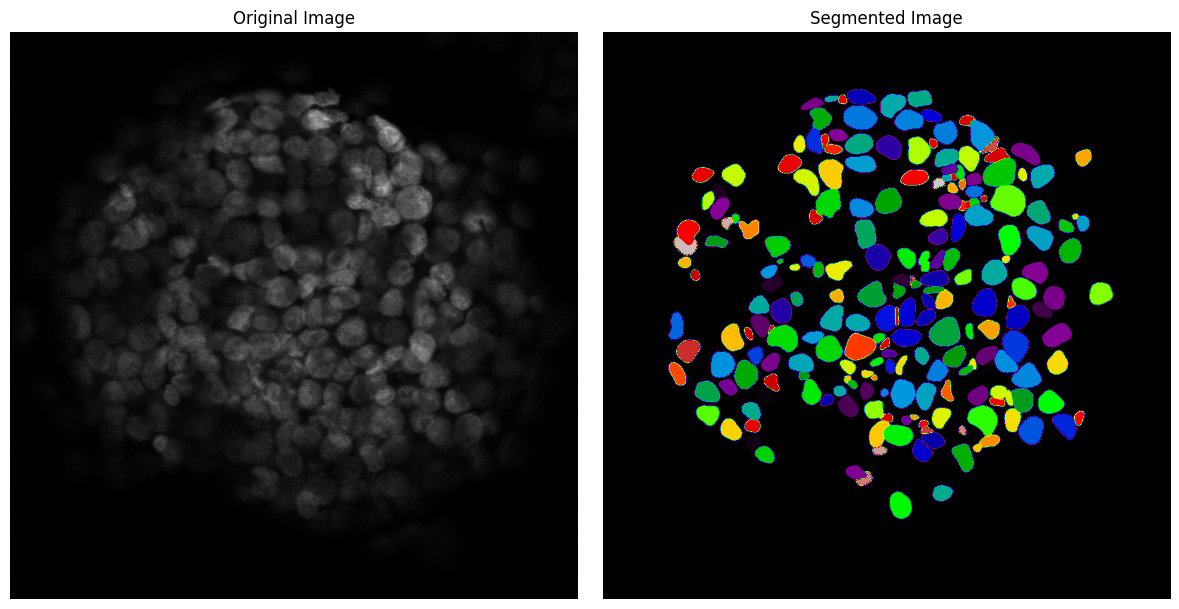

In [70]:
# Load pretrained StarDist 2D model for fluorescent images
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# Perform instance segmentation
labels, details = model.predict_instances(image_2d_norm)

# Save the segmented image
# Replace 'segmented_image_path.tif' with the path where you want to save the segmented 2D image
# tifffile.imsave('segmented_image_path.tif', labels.astype(np.uint16))

# Plotting the original and segmented images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes.ravel()

ax[0].imshow(image_2d_norm, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(labels, cmap='nipy_spectral')
ax[1].set_title("Segmented Image")
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [71]:
viewer.add_labels(labels, name='Segmented Nuclei')

<Labels layer 'Segmented Nuclei' at 0x7fc1b42bf3a0>

In [73]:
# viewer.layers['nuclei_channel'].data=nuclei_channel

Bastante mal la verdad...